
# Import Python libraries.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import seaborn as sns

# Import Datasets

In [71]:
train_data = pd.read_csv('/content/Training Data.csv')
test_data = pd.read_csv('/content/Test Data.csv')

# Check how train dataset looks like.

In [72]:
train_data.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


#Check how many categorical variables are there

In [73]:
train_data.dtypes.value_counts()
print("There are {} categorical variables".format(train_data.dtypes.value_counts()[1]))

There are 6 categorical variables


# Convert datatype of selected fields.


In [74]:
# A function to encode the categorical variables
def labelling(data):
  label_encoded_cols = 0
  for i in data:
    if data[i].dtype=='object':
      data[i] = pd.factorize(data[i])[0]
      label_encoded_cols+=1
  print("Total label encoded columns = ",label_encoded_cols)

In [75]:
labelling(train_data) # encoding categorical values of train_data

Total label encoded columns =  6


In [76]:
labelling(test_data) # encoding categorical values of test_data

Total label encoded columns =  6


#Some Exploratory Data Analysis
1) Checking for null values<br>
2) Feature selection through variance determination<br>
3) Scaling

<h4>Checking for null values</h4>

In [77]:
def plot_missing_data(df):
    '''
    This function accepts a dataframe.
    For this dataframe, the function
    1. computes percentage of missing value for each column, and,
    2. plots the data in a graph.
    INPUT:
    df - dataframe on which missing data % needs to be computed and plotted
    OUTPUT: Plot on missing data
    '''
    fig = plt.figure(figsize=(18,6))
    
    # percentage of missing data in the dataframe
    missing = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
    
    ax = sns.pointplot("index", 0, data=missing)
    plt.xticks(rotation=90, fontsize=7)
    plt.title('Percentage of missing values in the data')
    plt.ylabel('PERCENTAGE')
    plt.xlabel('COLUMNS')
    ax.set_facecolor('k')
    fig.set_facecolor('lightgrey')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


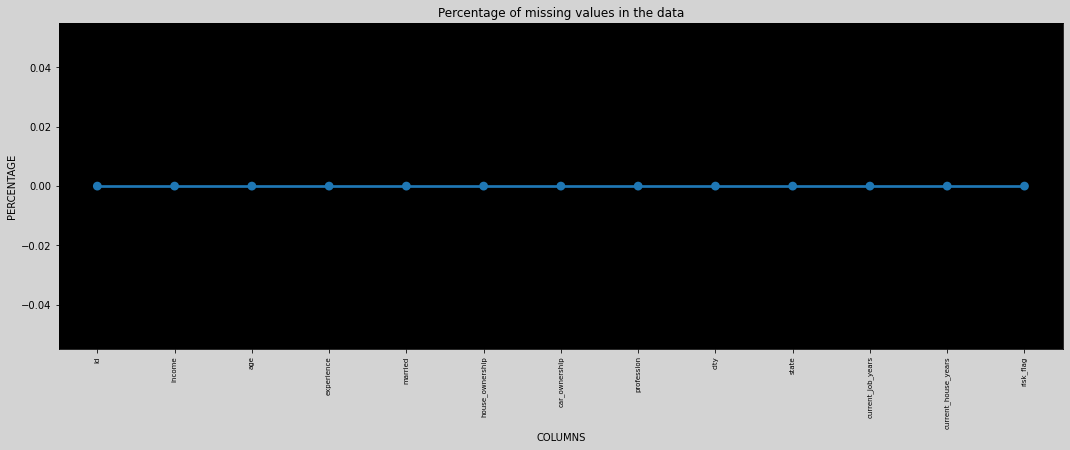

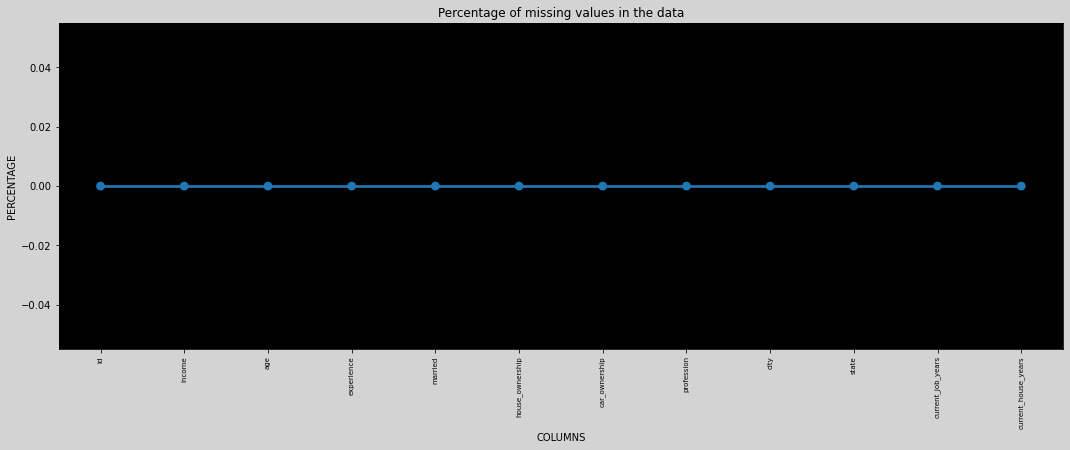

In [78]:
plot_missing_data(train_data)# plot for train data missing values
plot_missing_data(test_data)# plot for test data missing values

In [ ]:
# from the above plots we can se that there is no missing values

<h4>Feature selection</h4>
Here I think the 'city', 'state', 'profession' features don't contribute much variance to the data as can been seen from the code, so I am discarding them from the final dataset

In [79]:
train_data_new = train_data.drop(['city','state','profession','Id'],axis=1)

In [80]:
train_data_new.head()

,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years,risk_flag
0,1303835,23,3,0,0,0,3,13,0
1,7574516,40,10,0,0,0,9,13,0
2,3991815,66,4,1,0,0,4,10,0
3,6256451,41,2,0,0,1,2,12,1
4,5768871,47,11,0,0,0,3,14,1


In [81]:
test_data_new = test_data.drop(['city','state','profession','id'],axis=1)

In [82]:
test_data_new.head()

,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years
0,7393090,59,19,0,0,0,4,13
1,1215004,25,5,0,0,0,5,10
2,8901342,50,12,0,0,0,9,14
3,1944421,49,9,1,0,1,3,12
4,13429,25,18,0,0,1,13,11


<h4>Feature Scaling</h4>

In [83]:
from sklearn import preprocessing
scaler= preprocessing.MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data_new) 
train_data_scaled = pd.DataFrame(train_data_scaled,columns=train_data_new.columns)

In [84]:
train_data_scaled.head()

,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years,risk_flag
0,0.129487,0.034483,0.15,0.0,0.0,0.0,0.214286,0.75,0.0
1,0.757206,0.327586,0.50,0.0,0.0,0.0,0.642857,0.75,0.0
2,0.398564,0.775862,0.20,1.0,0.0,0.0,0.285714,0.00,0.0
3,0.625263,0.344828,0.10,0.0,0.0,1.0,0.142857,0.50,1.0
4,0.576454,0.448276,0.55,0.0,0.0,0.0,0.214286,1.00,1.0


In [85]:
test_data_scaled = scaler.fit_transform(test_data_new) 
test_data_scaled = pd.DataFrame(test_data_scaled,columns=test_data_new.columns)

In [86]:
test_data_scaled.head()

,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years
0,0.739054,0.655172,0.95,0.0,0.0,0.0,0.285714,0.75
1,0.120596,0.068966,0.25,0.0,0.0,0.0,0.357143,0.00
2,0.890037,0.500000,0.60,0.0,0.0,0.0,0.642857,1.00
3,0.193614,0.482759,0.45,1.0,0.0,1.0,0.214286,0.50
4,0.000312,0.068966,0.90,0.0,0.0,1.0,0.928571,0.25


#Feature selection verification through variance contribution by using PCA

In [87]:
pca = PCA()
pca.fit(train_data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
# function that plots the variance contribution of different features
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
print("Function 'scree_plot' has been defined.")


Function 'scree_plot' has been defined.


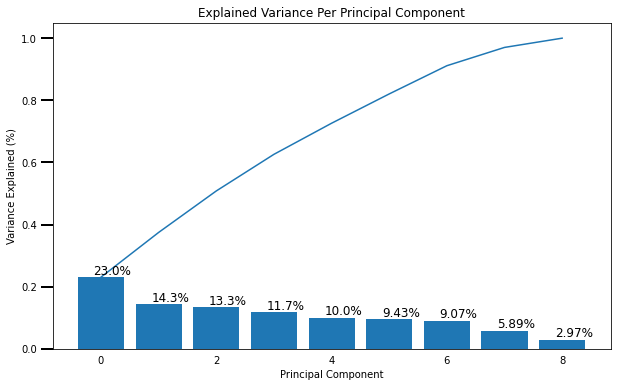

In [89]:
scree_plot(pca)

In [ ]:
#From the above plot its visible that 8 features excluding the target variable contribute 100% variance to data

#Train and test set split for training model

In [90]:
X = train_data_scaled.drop('risk_flag',axis=1)# dropping dependent and independent variables
Y = train_data_scaled['risk_flag']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30)

In [91]:
print("Number of samples in train set: ",X_train.shape)
print("Number of samples in test set: ",X_test.shape)

Number of samples in train set:  (176400, 8)
Number of samples in test set:  (75600, 8)


# Train your model

In [137]:
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Test your model 

In [138]:
y_pred = clf.predict(X_test)

# Check your roc_auc_score 

In [140]:
auc = roc_auc_score(y_pred, y_test)
print('ROC AUC: %f' % auc)

ROC AUC: 0.763220


In [141]:
from sklearn.metrics import classification_report
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n         0.0       0.94      0.95      0.94     66385\n         1.0       0.59      0.54      0.57      9215\n\n    accuracy                           0.90     75600\n   macro avg       0.76      0.75      0.75     75600\nweighted avg       0.89      0.90      0.90     75600\n'

# Filling out predictions for given test csv file

In [142]:
test_data_scaled.head()

,income,age,experience,married,house_ownership,car_ownership,current_job_years,current_house_years
0,0.739054,0.655172,0.95,0.0,0.0,0.0,0.285714,0.75
1,0.120596,0.068966,0.25,0.0,0.0,0.0,0.357143,0.00
2,0.890037,0.500000,0.60,0.0,0.0,0.0,0.642857,1.00
3,0.193614,0.482759,0.45,1.0,0.0,1.0,0.214286,0.50
4,0.000312,0.068966,0.90,0.0,0.0,1.0,0.928571,0.25


In [143]:
test_data_results = clf.predict(test_data_scaled)

In [144]:
test_data_results.shape

(28000,)

In [145]:
no_of_yes_classes = 0
no_of_no_classes = 0
for i in test_data_results:
  if i==1:
    no_of_yes_classes+=1
  else:
    no_of_no_classes+=1

print("The number of risk groups are: ",no_of_yes_classes,"\n")
print("The number of no risk groups are: ",no_of_no_classes,"\n")

The number of risk groups are:  3226 

The number of no risk groups are:  24774 



# Writing out predicted results to the output file

In [146]:
output_df = pd.DataFrame(test_data['id'])

In [147]:
output_df['risk_flag'] = test_data_results

In [148]:
output_df['risk_flag'] = output_df['risk_flag'].astype(int)#converting predictions to int from float

In [149]:
output_df.head()

,id,risk_flag
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [129]:
output_df.to_csv('output_UnivAi.csv',index=False) #converting the dataframe to an output csv file